In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

%matplotlib inline

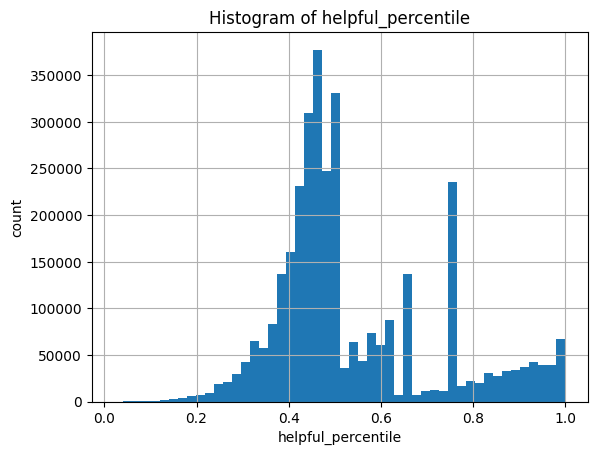

In [2]:
df = pd.read_pickle("df_processed_sentiment.pkl")
df = df.drop(columns=['asin', 'images_meta', 'categories', 'description', 'videos'])
df["helpful_percentile"] = df.groupby("parent_asin")["helpful_vote"].rank(pct=True)
df["is_helpful"] = (df["helpful_percentile"] >= 0.60).astype(int)
cond = (df['helpful_percentile'] == 1.0) & (df['helpful_vote'] < 5)
df = df.loc[~cond].reset_index(drop=True)

ax = df['helpful_percentile'].hist(bins=50)
ax.set_xlabel('helpful_percentile')
ax.set_ylabel('count')
ax.set_title('Histogram of helpful_percentile')
plt.show()


In [3]:
#Select 100000 random samples from the product categories All Beauty, AMAZON FASHION, Appliances and Health & Personal Care
#And get an 50% - 50% split of helpful and not helpful reviews 
df_sampled = pd.DataFrame()
for category in ['All Beauty', 'AMAZON FASHION', 'Appliances', 'Health & Personal Care']:
    df_category = df[df['main_category'] == category]
    df_helpful = df_category[df_category['is_helpful'] == 1].sample(n=100000, replace=True)
    df_not_helpful = df_category[df_category['is_helpful'] == 0].sample(n=100000, replace=True)
    df_sampled = pd.concat([df_sampled, df_helpful, df_not_helpful], ignore_index=True)


In [4]:
df = df_sampled.copy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["is_helpful"]), df["is_helpful"], test_size=0.3)
dropping_list = ['title_data', 'text', 'helpful_vote', 'title_meta', 'average_rating', 'rating_number', 'features', 'store', 'details', 'helpful_percentile', 'timestamp']
X_train = X_train.drop(columns=dropping_list)
X_test = X_test.drop(columns=dropping_list)
X_train = X_train.drop(columns=['user_id'])
X_test = X_test.drop(columns=['user_id'])

cols = ['parent_asin','main_category', 'sentiment']

# convert to pandas string dtype for both train and test
X_train[cols] = X_train[cols].astype('category')
X_test[cols] = X_test[cols].astype('category')

# verify
X_train[cols].dtypes, X_test[cols].dtypes




(parent_asin      category
 main_category    category
 sentiment        category
 dtype: object,
 parent_asin      category
 main_category    category
 sentiment        category
 dtype: object)

In [10]:
#Target Encoder code
from category_encoders import TargetEncoder
cat_cols = ["parent_asin","main_category", "sentiment"]
encoder = TargetEncoder(cols=cat_cols)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Confusion Matrix:
[[85077 34973]
 [34087 85863]]


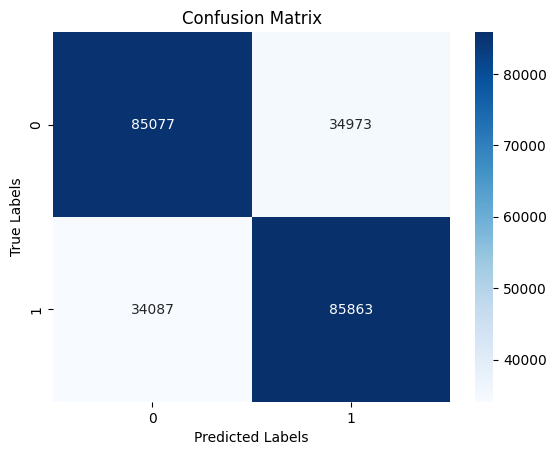

AUC Score: 0.7716


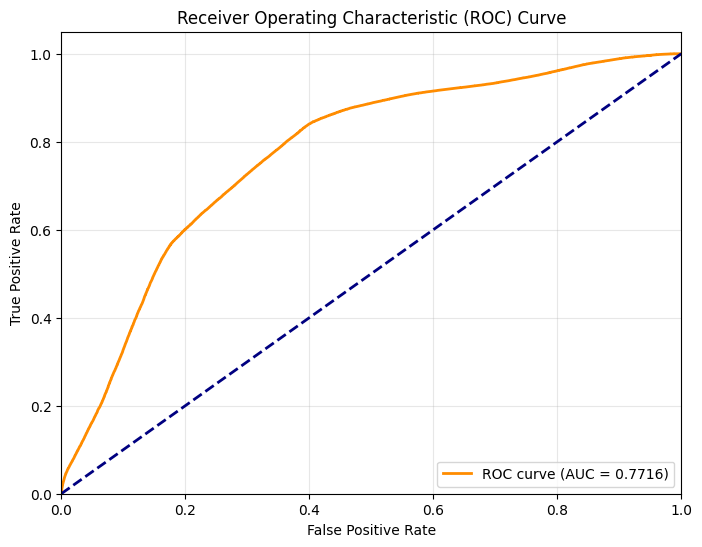

In [11]:
#LR Target Encoding

lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)
lr_model.fit(X_train_encoded, y_train)

y_pred = lr_model.predict(X_test_encoded)
y_proba = lr_model.predict_proba(X_test_encoded)[:, 1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Random Forest Classifier Accuracy: 0.7747875


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s


Confusion Matrix:
[[95965 24085]
 [29967 89983]]


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished


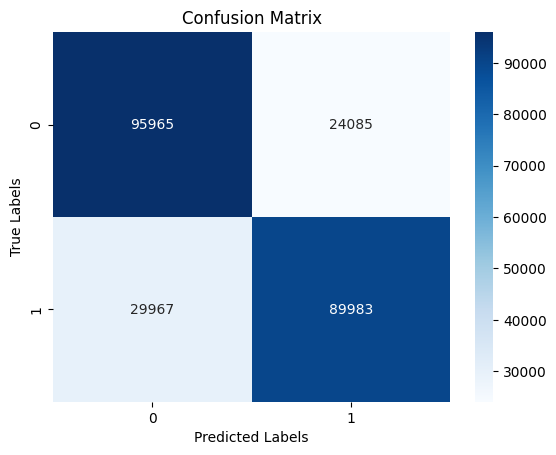

AUC Score: 0.8557


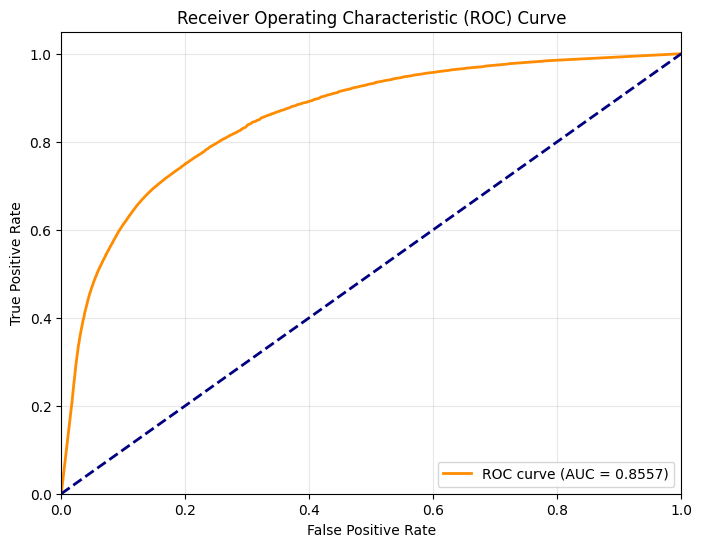

In [12]:
#RF Target Encoding
clf = RandomForestClassifier(n_jobs=-1, verbose=True)
clf.fit(X_train_encoded, y_train)

# print score of clf on X_test and y_test
print("Random Forest Classifier Accuracy:", clf.score(X_test_encoded, y_test))

# Predictions
y_pred = clf.predict(X_test_encoded)
y_proba = clf.predict_proba(X_test_encoded)[:, 1]  # for ROC/AUC, need probabilities for the positive class

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:00:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[93132 26918]
 [38636 81314]]


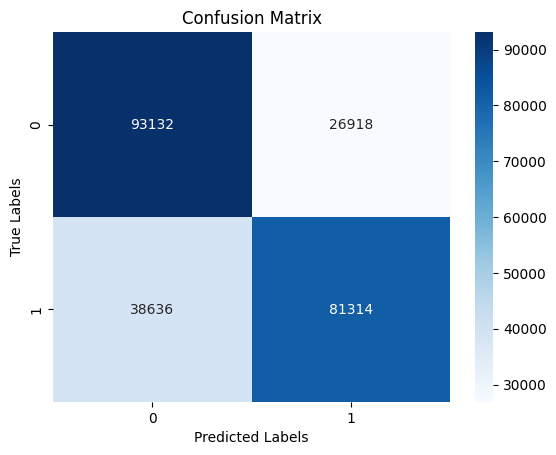

AUC Score: 0.8174


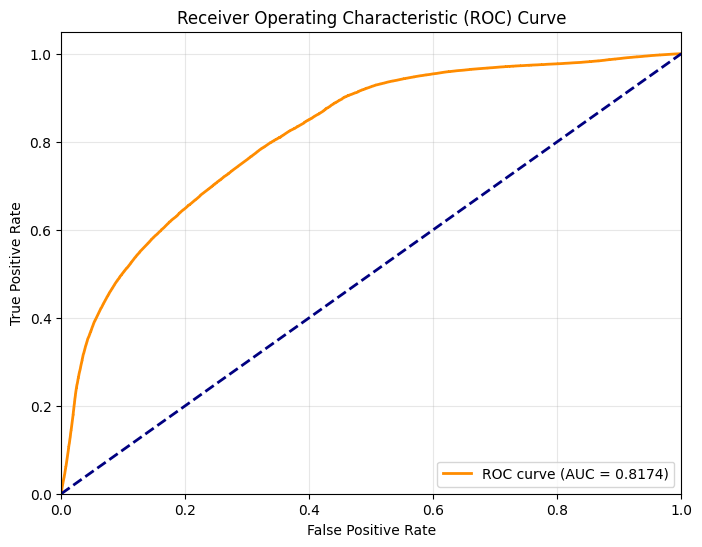

In [13]:
#XGBoost Target Encoding
n_estimators = 100

model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    tree_method='hist',        # use efficient histogram algorithm
    predictor='auto',          # auto-detect best predictor (GPU if available)
    enable_categorical=True,
    eval_metric='auc',
    verbosity=1,
    n_jobs=-1
    # callbacks=[TQDMProgressBar(total_rounds=n_estimators)]
)

# Train the model
model.fit(X_train_encoded, y_train)

# Predictions
y_pred = model.predict(X_test_encoded)
y_proba = model.predict_proba(X_test_encoded)[:, 1]  # for ROC/AUC, need probabilities for the positive class

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Iteration 1, loss = 0.54119125
Validation score: 0.810429
Iteration 2, loss = 0.48535136
Validation score: 0.801714
Iteration 3, loss = 0.45957479
Validation score: 0.814839
Iteration 4, loss = 0.43555271
Validation score: 0.815107
Iteration 5, loss = 0.42416917
Validation score: 0.818411
Iteration 6, loss = 0.41974514
Validation score: 0.810607
Iteration 7, loss = 0.41623083
Validation score: 0.820250
Iteration 8, loss = 0.41293050
Validation score: 0.822250
Iteration 9, loss = 0.40883968
Validation score: 0.820732
Iteration 10, loss = 0.40702085
Validation score: 0.817589
Iteration 11, loss = 0.40545625
Validation score: 0.820929
Iteration 12, loss = 0.40462960
Validation score: 0.824232
Iteration 13, loss = 0.40345408
Validation score: 0.822339
Iteration 14, loss = 0.40249350
Validation score: 0.821286
Iteration 15, loss = 0.40169763
Validation score: 0.819214
Iteration 16, loss = 0.40106230
Validation score: 0.823393
Iteration 17, loss = 0.40069945
Validation score: 0.825482
Iterat

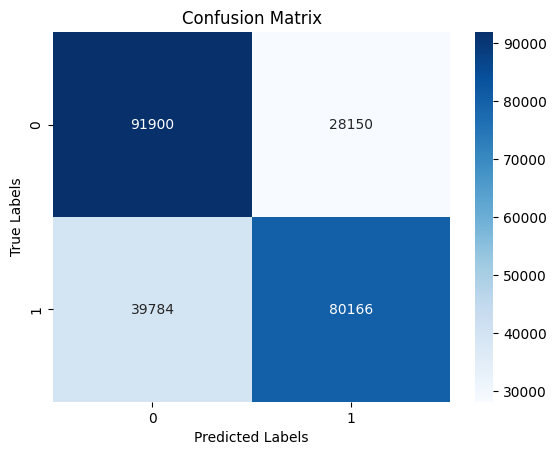

AUC Score: 0.8053


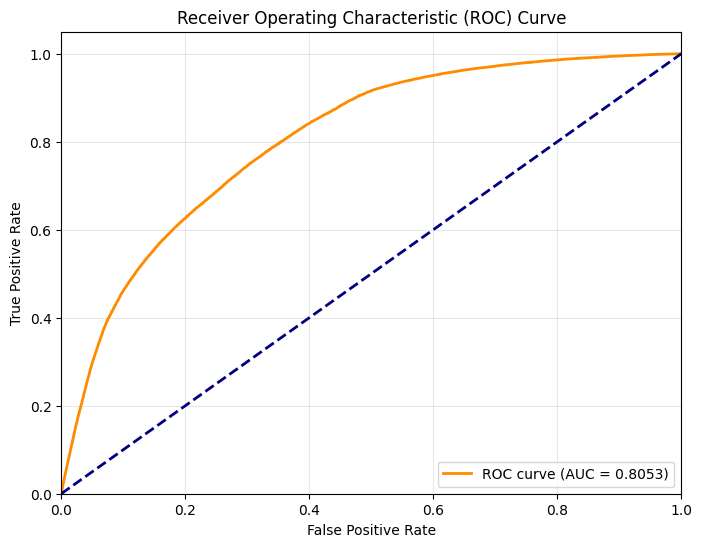

In [17]:
#MLP Target Encoding
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), 
    max_iter=500,
    activation='relu',
    solver='adam', 
    random_state=42,
    verbose=True,
    early_stopping=True 
)

mlp_model.fit(X_train_encoded, y_train)

# --- 4. Evaluation and Prediction (Mirroring your original pattern) ---
y_pred = mlp_model.predict(X_test_encoded)
y_proba = mlp_model.predict_proba(X_test_encoded)[:, 1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [22]:
# compute AUC per main_category
y_pred_series = pd.Series(clf.predict(X_test_encoded), index=y_test.index)
y_proba_series = pd.Series(clf.predict_proba(X_test_encoded)[:, 1], index=y_test.index)

rows = []
for cat, idx in X_test.groupby('main_category').groups.items():
    y_true_cat = y_test.loc[idx]
    y_pred_cat = y_pred_series.loc[idx]
    y_proba_cat = y_proba_series.loc[idx]
    try:
        auc = roc_auc_score(y_true_cat, y_proba_cat)
    except Exception:
        auc = float('nan')
    rows.append((cat, len(y_true_cat), auc))

pd.DataFrame(rows, columns=['main_category', 'n_samples', 'auc']).sort_values('main_category').reset_index(drop=True)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.2s finished
C:\Users\Niels\AppData\Local\Temp\ipykernel_37792\1541886128.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cat, idx in X_test.groupby('main_category').groups.items():


,main_category,n_samples,auc
0,AMAZON FASHION,60241,0.795852
1,All Beauty,60071,0.854339
2,Appliances,59945,0.886497
3,Health & Personal Care,59743,0.902133


In [23]:
# compute AUC per main_category
y_pred_series = pd.Series(model.predict(X_test_encoded), index=y_test.index)
y_proba_series = pd.Series(model.predict_proba(X_test_encoded)[:, 1], index=y_test.index)

rows = []
for cat, idx in X_test.groupby('main_category').groups.items():
    y_true_cat = y_test.loc[idx]
    y_pred_cat = y_pred_series.loc[idx]
    y_proba_cat = y_proba_series.loc[idx]
    try:
        auc = roc_auc_score(y_true_cat, y_proba_cat)
    except Exception:
        auc = float('nan')
    rows.append((cat, len(y_true_cat), auc))

pd.DataFrame(rows, columns=['main_category', 'n_samples', 'auc']).sort_values('main_category').reset_index(drop=True)

C:\Users\Niels\AppData\Local\Temp\ipykernel_37792\2651425155.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cat, idx in X_test.groupby('main_category').groups.items():


,main_category,n_samples,auc
0,AMAZON FASHION,60241,0.802518
1,All Beauty,60071,0.819740
2,Appliances,59945,0.823970
3,Health & Personal Care,59743,0.838365


In [18]:
feat_names = X_train_encoded.columns.tolist()

parent_asin          0.674332
review_length        0.178841
title_length         0.057203
main_category        0.029359
sentiment            0.021367
rating               0.020721
images_data          0.012550
verified_purchase    0.005626
dtype: float64


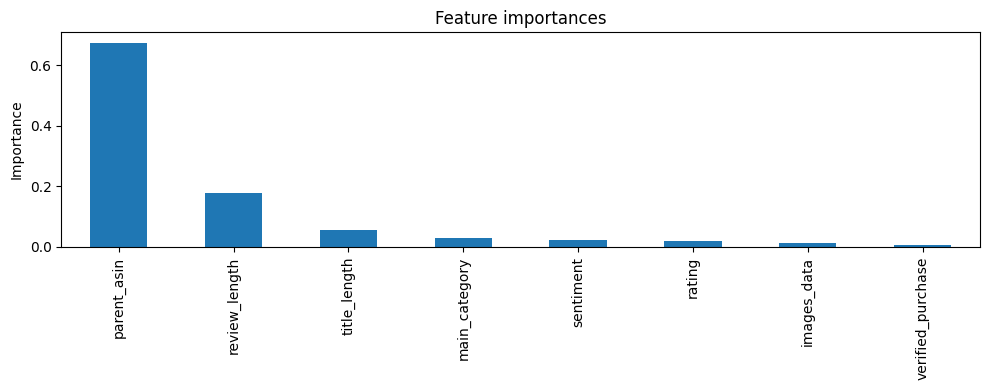

In [19]:
# show feature importances with featurenames
if hasattr(clf, "feature_importances_"):
    imp = clf.feature_importances_
else:
    # fallback for xgboost booster score (maps 'f0','f1',...)
    imp_dict = clf.get_booster().get_score(importance_type='gain')
    imp = [imp_dict.get(f"f{i}", 0.0) for i in range(len(feat_names))]

fi = pd.Series(imp, index=feat_names).sort_values(ascending=False)
print(fi)

# plot
fi.plot(kind='bar', figsize=(10, 4))
plt.title("Feature importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

parent_asin          0.640938
review_length        0.109556
main_category        0.075669
verified_purchase    0.069754
images_data          0.045737
rating               0.037220
sentiment            0.012288
title_length         0.008838
dtype: float32


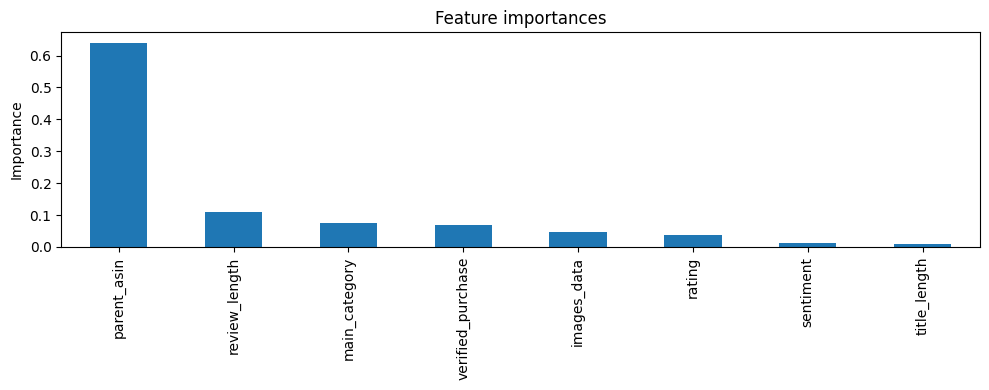

In [20]:
# show feature importances with featurenames
if hasattr(model, "feature_importances_"):
    imp = model.feature_importances_
else:
    imp_dict = model.get_booster().get_score(importance_type='gain')
    imp = [imp_dict.get(f"f{i}", 0.0) for i in range(len(feat_names))]

fi = pd.Series(imp, index=feat_names).sort_values(ascending=False)
print(fi)

# plot
fi.plot(kind='bar', figsize=(10, 4))
plt.title("Feature importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()